## Bayesian estimation of a univariate first-order autoregression

###### by David Evans, Chase Coleman, and Thomas Sargent

This notebook uses Bayesian methods offered by [pymc](https://github.com/pymc-devs/pymc) to estimate two parameters of a univariate first order VAR model.  We'll let $\{y_t\}_{t=0}^T$ denote the sample. 

The model is a good laboratory for illustrating some
important issues:  

* The consequences of alternative ways of modeling the distribution of the initial random variable $y_0$:

    * As a fixed number.
    
    * As a random variable drawn from the stationary distribution of the $\{y_t\}$ stochastic process
    

For those who don't have ``pymc`` installed, the process is straightforward as long as you are using [Anaconda](https://www.continuum.io/why-anaconda).  Assuming that you are, just execute the next cell.

In [1]:
!conda install -c https://conda.anaconda.org/anaconda pymc

Fetching package metadata: ......
Solving package specifications: .........................
# All requested packages already installed.
# packages in environment at /home/chase/Programming/anaconda3:
#
pymc                      2.3.6               np110py35_0  


### The model


The model is

$$ y_{t+1} = \rho y_t + \sigma_x \epsilon_{t+1}, \quad t \geq 0 $$

where the scalars $\rho$ and $\sigma_x$ satisfy $|\rho| < 1$ and $\sigma_x > 0$; and
$\{\epsilon_{t+1}\}$ is a sequence of i.i.d. normal random variables with mean $0$ and variance $1$;
and $y_0 \sim {\cal N}(\mu_0, \sigma_0^2)$  

Consider a sample $\{y_t\}_{t=0}^T$ governed by this statistical model.  The first-order autoregression
implies that the likelihood function of $\{y_t\}_{t=0}^T$ can be factored as follows:

$$ f(y_T, y_{T-1}, \ldots, y_0) = f(y_T| y_{T-1}) f(y_{T-1}| y_{T-2}) \cdots f(y_1 | y_0 ) f(y_0) $$

where we use $f$ to denote a probability density.  The statistical model above implies that

$$\eqalign{  f(y_t | y_{t-1}) & \sim {\mathcal N}(\rho y_{t-1}, \sigma_x^2) \cr
             f(y_0) & \sim {\mathcal N}(\mu_0, \sigma_0^2) }$$

A focus of the notebook is to study how inferences about the unknown parameters $(\rho, \sigma_x)$ depend on what is assumed, right or wrong, about the parameters $\mu_0, \sigma_0$  of the distribution of $y_0$.

We pretend that the parameters $\mu_0, \sigma_0$ are known numbers that may or may not be  functions of $\rho, \sigma_x$. Below, we compare two cases:

 * $y_0$ is drawn from the stationary distribution implied by $\rho, \sigma_x$.  In this case, $\mu_0,\sigma_0$ are functions of $\rho, \sigma_x$.
 
 * $y_0$ is  drawn from the distribution ${\mathcal N}(y_0, 0)$.  This amounts to conditioning on the initial value.  
 
Unknown parameters are $\rho, \sigma_x$. We know prior probability distributions for these two and want to compute a posterior probability distribution of them associated with a sample $\{y_{t}\}_{t=0}^T$.  

The notebook uses pymc to compute the posterior distribution of $\rho, \sigma_x$

**Note:** We do not treat $\mu_y,\sigma_y$ as parameters to be estimated. Instead we treat them either as fixed
parameters or as particular functions of $\rho, \sigma_x$.  In particular, we explore consequences of two alternative assumptions about the distribution of $y_0$: 


* The first procedure is to condition on whatever value of  $y_0$ is observed.  This amounts to assuming that the probability distribution of the random variable  $y_0$ is  a Dirac delta function that puts probability one  on the observed value of $y_0$.  It is as if $\mu_y = y_0, \sigma_y =0$.  

* The second procedure is to assume that $y_0$ is drawn from the stationary distribution of 
$$ y_{t+1} = \rho y_t + \sigma_x \epsilon_{t+1}, ,\quad t \geq 0, $$ namely, $y_0 \sim {\cal N} \left(0, {\sigma_x^2\over (1-\rho)^2} \right) $

When the initial value $y_0$ is far out in the tails of the stationary distribution, conditioning on the initial value gives a posterior that is "much more accurate", whatever that might mean to a Bayesian.  

Here is what is going on.  When you don't condition on $y_0$,  the likelihood function for $\{y_t\}_{t=0}^T$ adjusts the parameter pair $\rho, \sigma_x $ to make the observed value of $y_0$ much more  likely than it really is, thereby adversely twisting the posterior in short samples.

The example below shows how not conditioning on $y_0$ adversely shifts the posterior probability distribution of $\rho$ toward larger values.

In [2]:
%matplotlib inline
import pymc as pmc
import numpy as np
import matplotlib.pyplot as plt

First simulate an AR(1) process.

How we select the initial value $y_0$ matters.

   * If we think $y_0$ is drawn from the stationary distribution ${\mathcal N}(0, \frac{\sigma_x}{1-\rho^2})$, then it is a good idea to use this distribution as $f(y_0)$.  Why? Because $y_0$ contains some information
   about $\rho, \sigma_x$.  
   
   * If we suspect that $y_0$ is far in the tails of the stationary distribution -- so that variation in early observations in the sample have a significant transient component -- it is better to condition on $y_0$ by setting $f(y_0) = 1$.
   

To illustrate the issue, we'll begin by choosing an initial $y_0$ that is far out in the stationary distribution.

In [3]:
def ar1_simulate(rho, sigma, y0, T):

    # Allocate space and draw epsilons
    y = np.empty(T)
    eps = np.random.normal(0.,sigma,T)

    # Initial condition and step forward
    y[0] = y0
    for t in range(1, T):
        y[t] = rho*y[t-1] + eps[t]
        
    return y

sigma =  1.
rho = 0.5
T = 50

np.random.seed(145353452)
y = ar1_simulate(rho, sigma, 10, T)

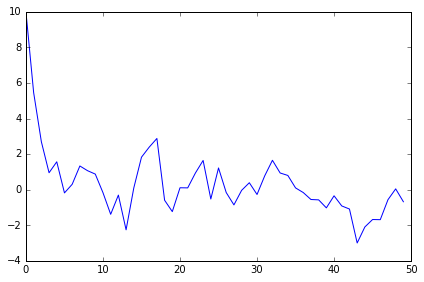

In [4]:
plt.plot(y)
plt.tight_layout()

Now we shall use  Bayes law, conditioning on the initial value of $y_0$. (Later we'll assume that $y_0$ is drawn from the stationary distribution, but not now.)


In [5]:
def AR1_model():
        
    #start with priors
    rho = pmc.Uniform('rho',lower=-1.,upper=1.) #assume stable rho
    sigma = pmc.HalfNormal('sigma', tau = 0.1)
    
    # Expected value of y at the next period (rho * y)
    yhat = rho*y[:-1]
    
    # Likelihood of the actual realization.
    y_like = pmc.Normal('y_obs', mu = yhat, tau=1./sigma, observed=True,value=y[1:])

    return locals()

In [6]:
AR1_MCMC = pmc.MCMC(AR1_model())

In [7]:
AR1_MCMC.sample(50000,burn = 10000)

 [-----------------100%-----------------] 50000 of 50000 complete in 4.7 sec

Plotting sigma
Plotting rho


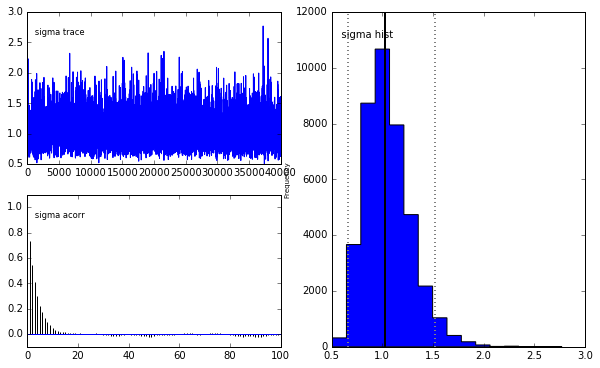

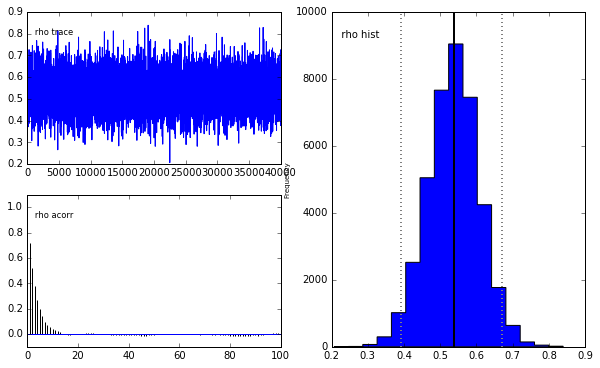

In [8]:
pmc.Matplot.plot(AR1_MCMC)

Notice how the posteriors are centered on the true values hard wired in above

Here is more detail about the posterior

In [9]:
AR1_MCMC.summary()


sigma:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	1.055            0.229            0.003            [ 0.664  1.517]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.697            0.89            1.025          1.184         1.583
	

rho:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.536            0.071            0.001            [ 0.39   0.671]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.393            0.49            0.537          0.583         0.675
	


Now we shall use Bayes Law but shall assume that $y_0$ is drawn from the stationary distribution. This means that we expect the value of $y_0$ to come from

$$y_0 \sim N \left(0, \frac{\sigma_x}{1 - \rho} \right)$$

Note how the code has been altered to achieve this

In [10]:
def AR1_model_y0():
        
    #start with priors
    rho = pmc.Uniform('rho',lower=-1.,upper=1.) #assume stable rho
    sigma = pmc.HalfNormal('sigma', tau = 0.1)
    
    #standard deviation of ergodic y
    @pmc.deterministic(trace=False)
    def y_sd(rho = rho, sigma = sigma):
        return sigma/np.sqrt(1-rho**2)
    
    #yhat
    yhat = rho*y[:-1]
    y_data = pmc.Normal('y_obs', mu = yhat, tau=1./sigma, observed=True,value=y[1:])
    y0_data = pmc.Normal('y0_obs',mu = 0., tau= 1./y_sd, observed = True, value = y[0])
    
    return locals()

In [11]:
AR1_MCMC_y0 = pmc.MCMC(AR1_model_y0())

In [12]:
AR1_MCMC_y0.sample(50000,burn = 10000,thin=10)

 [-----------------100%-----------------] 50000 of 50000 complete in 4.9 sec

#### Some nerdy comments about how pymc works

The `pymc` package expects the model function to return all of its local variables by returning `locals()`. Remember that a model is simply a probability distribution over outcomes and for a Bayesian this probability distribution is determined by the posterior. The posterior is the product of the priors and the likelihood. The way `pymc` deals with this is by identifying which variables are stochastic and which are deterministic (one can also specify whether a variable is deterministic or stochastic by using the `@pymc.deterministic` or `@pymc.stochastic` decorators as explained in the `pymc` [documentation](https://pymc-devs.github.io/pymc/modelfitting.html#creating-models). The stochastic variables will be either priors (such as the distributions on $\rho$ and $\sigma$ in our case) or likelihoods (the probability of seeing a specific history of $y$ values). Thus `pymc` knows that the posterior probability will just be the product of all of the stochastic values.


Plotting sigma
Plotting rho


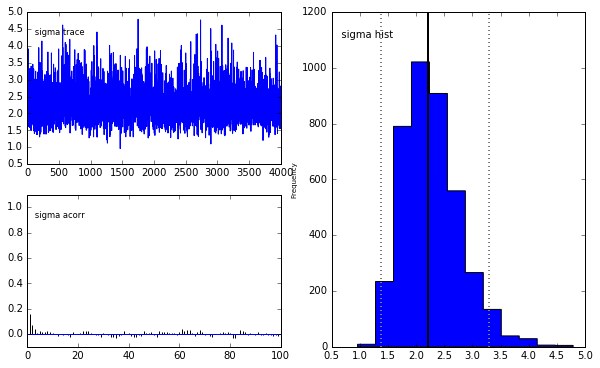

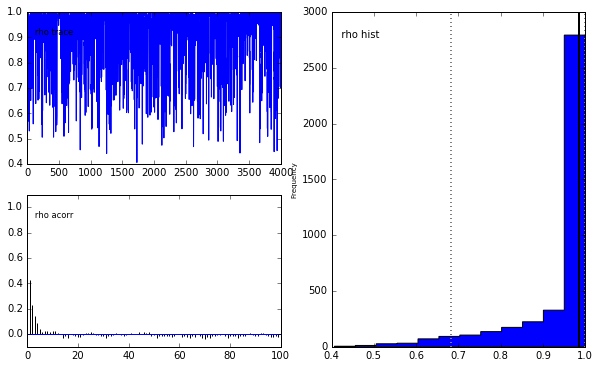

In [13]:
pmc.Matplot.plot(AR1_MCMC_y0)

Look what happened to the posterior! It has moved far from the true values of the parameters used to generate the data because poor Bayes Law is struggling to fit the early "explosive" observations. The way in which Bayes Law is able to generate a reasonable likelihood for the first observation is by driving $\rho \rightarrow 1$ and $\sigma \uparrow$ in order to raise the variance of the stationary distribution.

This small example highlights the importance of specifying your initial conditions in the proper way. If initial conditions are improperly specified then your estimates will be very far from their true values and may tell a different story than they would otherwise have told.
